# 3. Gráficos complementares

Gráficos para complementarem a apresentação do case

### importando as bibliotecas necessárias

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from scipy.stats import f_oneway

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

%matplotlib inline

### lendo as bases tratadas

In [3]:
demographic_data = pd.read_csv('dados_tratados/demographic_data_trat.csv')
df_geocode = pd.read_csv('dados_tratados/df_geocode_trat.csv')
economic_data = pd.read_csv('dados_tratados/economic_data_trat.csv')
test_data = pd.read_csv('dados_tratados/test_data_trat.csv')
transactional_data = pd.read_csv('dados_tratados/transactional_data_trat.csv')

zipcodes_states = pd.read_excel('dados_brutos/zipcodes-states.xlsx', index_col = 0) # fontes: https://codigo-postal.co/pt-br/eua/, https://pt.wikipedia.org/wiki/Lista_de_estados_dos_Estados_Unidos_por_popula%C3%A7%C3%A3o

c:\Users\Leticia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning:

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.



### gráfico do número de exames por mês - versão em linhas

In [5]:
exames_mes = transactional_data

exames_mes['Date of service'] = pd.to_datetime(exames_mes['Date of service'])

exames_mes['mes'] = exames_mes['Date of service'].dt.strftime('%b')
exames_mes['ano'] = exames_mes['Date of service'].dt.strftime('%y')

ordem = exames_mes.sort_values('Date of service')[['mes', 'ano']].drop_duplicates()
ordem['mes_ano'] = ordem['mes'] + '/' + ordem['ano']

ordem = ordem.reset_index().reset_index()
ordem = ordem.drop(['index'], axis = 1)
ordem = ordem.rename({'level_0':'mes_ordem'}, axis = 1)
ordem['mes_ordem'] = ordem['mes_ordem'] + 1

exames_mes2 = exames_mes
exames_mes2['mes_ano'] = exames_mes2['mes'] + '/' + exames_mes2['ano']
exames_mes2 = exames_mes2.groupby('mes_ano').count()['CodItem'].reset_index().merge(ordem[['mes_ano', 'mes_ordem']], how = 'left').sort_values('mes_ordem').reset_index()
exames_mes2 = exames_mes2.drop('index', axis = 1)
exames_mes2 = exames_mes2.rename({'CodItem':'Número de exames'}, axis = 1)
exames_mes2.head()

,mes_ano,Número de exames,mes_ordem
0,Jan/19,93203,1
1,Feb/19,84560,2
2,Mar/19,102251,3
3,Apr/19,93955,4
4,May/19,91182,5


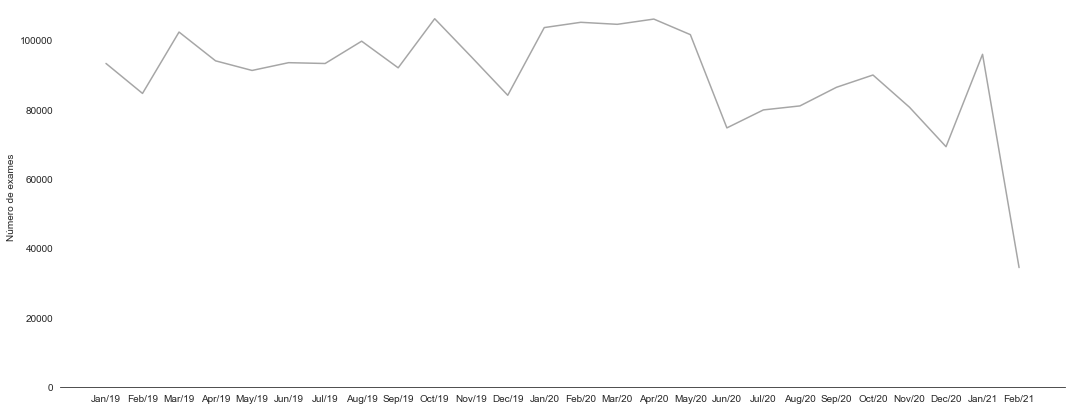

In [10]:
# gráfico

plt.figure(figsize = (18, 7))
sns.set_style('white')
fig = sns.lineplot(data = exames_mes2, x = 'mes_ano', y = 'Número de exames', color = '#a6a6a6')

# remover o título do eixo x
fig.set_xlabel('')

fig.set_ylim(0,)
# remover as bordas do gráfico
sns.despine(left = True)

### gráfico de mapa com bolhas com o valor médio dos exames por laboratório